# Classical Fully Connected Artificial Neural Network for Seismic Impedance Inversion

Seismic impedance inversion is an important problem in geophysics, and is often used for reservoir investigation and characterization. Impedance is usually calculated through

Here, we design a simple fully connected neural network with a variable number of hidden layers, in order to estimate seismic impedance, and find that even with a fairly straightforward architecture, we are able to capture the nature of the impedance traces well.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import math
from random import randint
from shutil import copyfile
from numpy import genfromtxt

import torch 
import torch.nn as nn
import torch.autograd
from random import randint
import torch.nn.functional as F
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# loading the data
seismic_data = genfromtxt('seismic_trace_15_9_F-15-A.csv', delimiter=';')
ricker = genfromtxt('statistical_source_wavelet.txt', delimiter='	')[:, 1] #Ricker wavelet for convolution


time_seismic = -np.round(seismic_data[:,0])
time_seismic, unique_indices = np.unique(time_seismic, return_index=True)

seismic_trace = seismic_data[unique_indices,1]
Ip_trace = seismic_data[unique_indices,2]

start_time = 2340.0
end_time = 2500.0

seismic_trace_cropped = seismic_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
Ip_trace_cropped = Ip_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
time_cropped = time_seismic[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]

# Data normalization
scaler_seismic = MinMaxScaler()
seismic_trace_cropped_normalized = scaler_seismic.fit_transform(seismic_trace_cropped.reshape(-1, 1)).flatten()

scaler_ip = MinMaxScaler()
Ip_trace_cropped_normalized = scaler_ip.fit_transform(Ip_trace_cropped.reshape(-1, 1)).flatten()

We define a simple neural network with a dynamic number of hidden layers, each with a customizable size. Each layer is a linear fully connected layer, and we apply ReLU as the activation function after each layer. 

In [3]:
class FCNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim_array = []): 
        super(FCNN, self).__init__()
        self.fc_linear = [] # fully connected layers empty list
        self.hidden_layers = len(hidden_dim_array)
        for l in range(self.hidden_layers):
            self.fc_linear.append(nn.Linear(input_dim, hidden_dim_array[l]))
            input_dim = hidden_dim_array[l]
        self.fc_linear = nn.ModuleList(self.fc_linear)
        self.out_layer = nn.Linear(input_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, input):
        #propagation of input through the network
        output = input
        for i in range(self.hidden_layers):
            output = self.fc_linear[i](output)
            output = self.relu(output)
        output = self.out_layer(output)
        return output

We first train this model with a single sample pair, consisting of a seismic trace, and the corresponding seismic impedance. We can see that the estimation of the impedance is highly accurate. Since the length of both arrays is 161, we use that as our input and output layers' dimensions, while keeping a hidden dimension of size 200. We use Adam optimization with a learning rate of 0.002, along with a Mean Squared Error loss function. We run this for 50 epochs and are able to correctly capture the behavior of the seismic impedance as it is mapped from the seismic trace

In [4]:
#creating tensors for use in the neural net
strace_tensor = torch.FloatTensor(seismic_trace_cropped_normalized)
Ip_tensor = torch.FloatTensor(Ip_trace_cropped_normalized)

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 387.14it/s]

Epoch [10/50], Loss: 0.0094
Epoch [20/50], Loss: 0.0038
Epoch [30/50], Loss: 0.0015
Epoch [40/50], Loss: 0.0005
Epoch [50/50], Loss: 0.0002


Text(0.5, 1.0, 'Loss over Epochs')

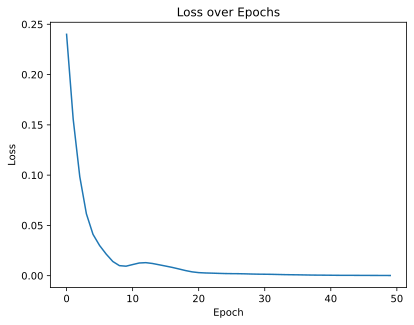

In [5]:
torch.manual_seed(42)

input_size = 161
hidden_size = [200]
output_size = 161

model = FCNN (input_size, output_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
epochs = 50

loss_list = []

for epoch in tqdm.trange (epochs):
    outputs = model(strace_tensor)
    loss = criterion(outputs, Ip_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    #print every 10th epoch's loss value
    if epoch%10 == 9:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")

Mean Squared Error (MSE): 0.00016036756278481334
R-squared (R2) Score: 0.9969996999337961
Mean Absolute Error (MAE): 0.009977390989661217
Accuracy (within threshold 0.05): 100.00%


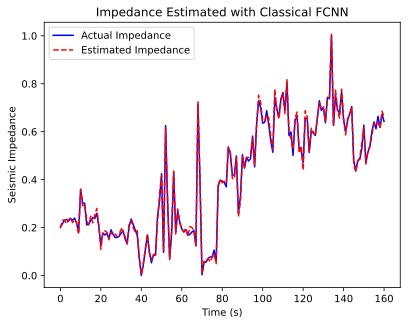

In [6]:
with torch.no_grad():
    sol = model(strace_tensor)
    
mse = mean_squared_error(Ip_tensor, sol)
r2 = r2_score(Ip_tensor, sol)
mae = mean_absolute_error(Ip_tensor, sol)
# Custom accuracy metric
threshold = 0.05
accuracy = np.mean(np.abs(Ip_tensor.detach().numpy() - sol.detach().numpy()) <= threshold) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2) Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Accuracy (within threshold {threshold}): {accuracy:.2f}%")


plt.plot(Ip_tensor, 'b', label = 'Actual Impedance')
plt.plot(sol.detach().numpy(), 'r--', label = 'Estimated Impedance')
plt.legend()
plt.title("Impedance Estimated with Classical FCNN")
plt.xlabel("Time (s)")
plt.ylabel("Seismic Impedance")
plt.show()

#### Now training and testing model with more data:

We use the stochastically generated impedance data, obtained from Vishal Das' [github repository](https://github.com/vishaldas/CNN_based_impedance_inversion/tree/master). In order to properly prepare the data for further use via normalization and convolution with the Ricker wavelet, we utilize the code from [this file](https://github.com/vishaldas/CNN_based_impedance_inversion/blob/master/Volve_field_example/Train_based_on_Volve_data.ipynb), which we also compare our results with in order to verify correct behavior of the code.

In [7]:
# Load stochastically generated impedance 
Ip = np.loadtxt('Ip_exported.txt')
Ip_reshape = np.reshape(Ip, ((151,151,160)), order='F')

# Trace by trace normalization and convolution, since convolution with impedance gives back the seismic trace data
ss_norm = np.zeros(Ip_reshape.shape)
Ip_norm = np.zeros(Ip_reshape.shape)
for i in range(Ip_reshape.shape[0]):
    for j in range(Ip_reshape.shape[1]):
#         scaler_Ip = MinMaxScaler()
#         scaler_ss = MinMaxScaler()
        Ip_trace = Ip_reshape[i,j,:] #.reshape(1, -1)
        Ip_norm[i,j,:] = (Ip_trace - np.min(Ip_trace))/(np.max(Ip_trace) - np.min(Ip_trace))
#         Ip_norm[i,j,:] = scaler_Ip.fit_transform(Ip_trace)
        r0_trace = 0.5*np.diff(np.log(Ip_trace))
        r0_trace = np.insert(r0_trace,0, 0)
        ss_trace = np.convolve(r0_trace, ricker, mode='same') # .reshape(1, -1)
        ss_norm[i,j,:] = (ss_trace - np.min(ss_trace))/(np.max(ss_trace) - np.min(ss_trace))
#         ss_norm[i,j,:] = scaler_ss.fit_transform(ss_trace)

In [8]:
# Creating training and testing data, referenced from Vishal Das repository

# Testing dataset created near the area of the well
indx_i_well_start, indx_i_well_end = 20, 45
indx_j_well_start, indx_j_well_end = 32, 54

seismic_test = ss_norm[indx_i_well_start:indx_i_well_end, indx_j_well_start:indx_j_well_end, :]
seismic_test = torch.FloatTensor(seismic_test.reshape(-1, seismic_test.shape[-1]))


Ip_test = Ip_norm[indx_i_well_start:indx_i_well_end, indx_j_well_start:indx_j_well_end, :]
Ip_test = torch.FloatTensor(Ip_test.reshape(-1, Ip_test.shape[-1]))

# Flatten rest of indices 
ss_data_rest = ss_norm[np.r_[0:(indx_i_well_start-1),(indx_i_well_end+1):ss_norm.shape[0]], :, :]
ss_data_rest = ss_data_rest[:, np.r_[0:(indx_j_well_start-1),(indx_j_well_end+1):ss_norm.shape[1]],:]
ss_data_rest = ss_data_rest.reshape(-1, ss_data_rest.shape[-1])

Ip_data_rest = Ip_norm[np.r_[0:(indx_i_well_start-1),(indx_i_well_end+1):Ip_norm.shape[0]], :, :]
Ip_data_rest = Ip_data_rest[:, np.r_[0:(indx_j_well_start-1),(indx_j_well_end+1):Ip_norm.shape[1]],:]
Ip_data_rest = Ip_data_rest.reshape(-1, Ip_data_rest.shape[-1])

# Selecting randomly training dataset
samples = 750 # Seismic samples considered
np.random.seed(42) # For replication of results
indxRand = [randint(0,ss_data_rest.shape[0]-1) for p in range(0,samples)] # choosing random indices to create the training set

seismic_train = (ss_data_rest[indxRand, :])
seismic_train = torch.FloatTensor(np.reshape(seismic_train, (seismic_train.shape[0], seismic_train.shape[1])))

Ip_train = (Ip_data_rest[indxRand, :])
Ip_train = torch.FloatTensor(np.reshape(Ip_train, (Ip_train.shape[0], Ip_train.shape[1])))

# now we have 750 samples for the training set each with signals of length 160
print(Ip_train.shape)
print(seismic_train.shape)

torch.Size([750, 160])
torch.Size([750, 160])


 18%|██████████████▍                                                                 | 36/200 [00:00<00:00, 181.65it/s]

Epoch [1/200], Loss: 0.3889
Epoch [11/200], Loss: 0.1052
Epoch [21/200], Loss: 0.0859
Epoch [31/200], Loss: 0.0745


 38%|██████████████████████████████▊                                                 | 77/200 [00:00<00:00, 190.29it/s]

Epoch [41/200], Loss: 0.0652
Epoch [51/200], Loss: 0.0576
Epoch [61/200], Loss: 0.0516
Epoch [71/200], Loss: 0.0471


 59%|██████████████████████████████████████████████▌                                | 118/200 [00:00<00:00, 194.41it/s]

Epoch [81/200], Loss: 0.0438
Epoch [91/200], Loss: 0.0414
Epoch [101/200], Loss: 0.0396
Epoch [111/200], Loss: 0.0383


 79%|██████████████████████████████████████████████████████████████▍                | 158/200 [00:00<00:00, 193.77it/s]

Epoch [121/200], Loss: 0.0374
Epoch [131/200], Loss: 0.0367
Epoch [141/200], Loss: 0.0362
Epoch [151/200], Loss: 0.0357


100%|██████████████████████████████████████████████████████████████████████████████▌| 199/200 [00:01<00:00, 197.51it/s]

Epoch [161/200], Loss: 0.0352
Epoch [171/200], Loss: 0.0348
Epoch [181/200], Loss: 0.0344
Epoch [191/200], Loss: 0.0340


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 192.23it/s]


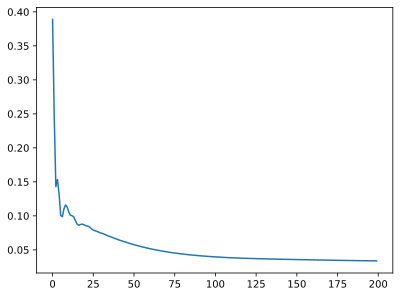

In [9]:
torch.manual_seed(42)

input_size = 160
hidden_size = [200]
output_size = 160

model2 = FCNN (input_size, output_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.003)
epochs = 200

loss_list = []

for epoch in tqdm.trange (epochs):
    outputs = model2(seismic_train)
    loss = criterion(outputs, Ip_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch%10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_list)

Mean Squared Error (MSE): 0.03668366000056267
R-squared (R2) Score: 0.5603134476033084
Mean Absolute Error (MAE): 0.15398547053337097


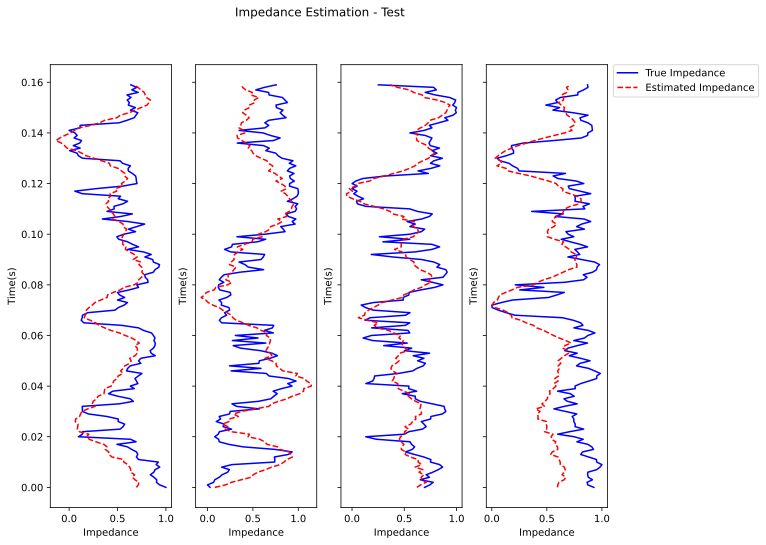

In [10]:
with torch.no_grad():
    out = model2(seismic_test)

mse = mean_squared_error(Ip_test, out)
r2 = r2_score(Ip_test, out)
mae = mean_absolute_error(Ip_test, out)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2) Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")


time = np.arange(0, 160*1e-3, 1e-3)
fig, axes = plt.subplots(1, 4, figsize=(10, 8), sharey=True)
fig.suptitle(f"Impedance Estimation - Test")
indices = [0, 10, 27, 42]  # Random indices for samples to plot

for i, ax in enumerate(axes):
    recon2plot = out.detach().numpy().transpose()[:, indices[i]]
    line1, = ax.plot(Ip_test.detach().numpy().transpose()[:, indices[i]], time, 'b', label="Original")
    line2, = ax.plot(recon2plot, time, 'r--', label="Estimated Impedance")
    ax.set_xlabel("Impedance")
    ax.set_ylabel("Time(s)")
#     ax.legend()
lgd = plt.legend((line1, line2), ('True Impedance', 'Estimated Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We will now use more hidden layers to create a deep neural network, but each layer with a smaller size than before, and compare the results.

 21%|████████████████▊                                                               | 42/200 [00:00<00:00, 207.68it/s]

Epoch [1/200], Loss: 0.3801
Epoch [11/200], Loss: 0.1118
Epoch [21/200], Loss: 0.0926
Epoch [31/200], Loss: 0.0873
Epoch [41/200], Loss: 0.0836


 49%|███████████████████████████████████████▏                                        | 98/200 [00:00<00:00, 252.75it/s]

Epoch [51/200], Loss: 0.0792
Epoch [61/200], Loss: 0.0739
Epoch [71/200], Loss: 0.0689
Epoch [81/200], Loss: 0.0647
Epoch [91/200], Loss: 0.0606
Epoch [101/200], Loss: 0.0568


 76%|████████████████████████████████████████████████████████████▍                  | 153/200 [00:00<00:00, 262.16it/s]

Epoch [111/200], Loss: 0.0533
Epoch [121/200], Loss: 0.0502
Epoch [131/200], Loss: 0.0469
Epoch [141/200], Loss: 0.0440
Epoch [151/200], Loss: 0.0419
Epoch [161/200], Loss: 0.0404


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 252.35it/s]


Epoch [171/200], Loss: 0.0393
Epoch [181/200], Loss: 0.0386
Epoch [191/200], Loss: 0.0380
Mean Squared Error (MSE): 0.040240176022052765
R-squared (R2) Score: 0.5179687232462056
Mean Absolute Error (MAE): 0.1622818410396576


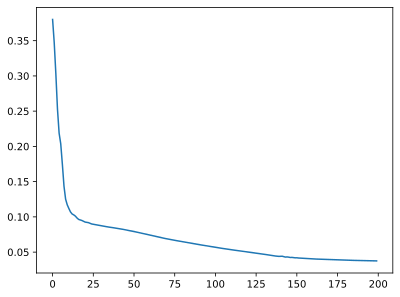

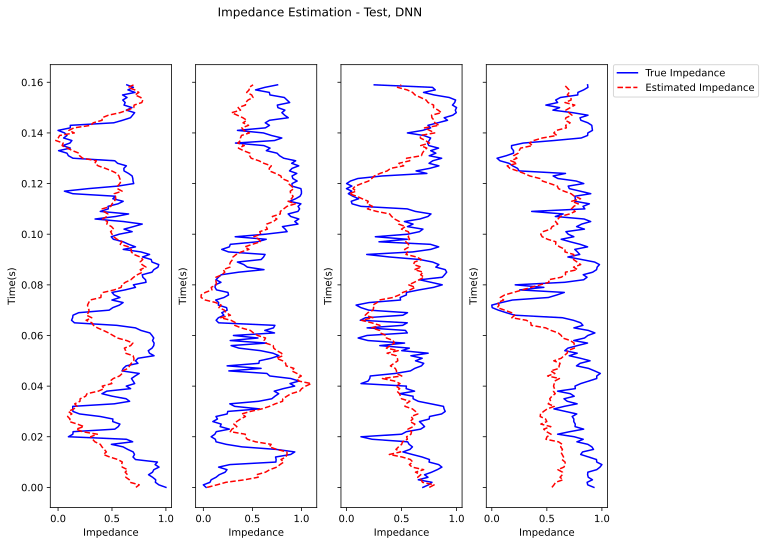

In [11]:
torch.manual_seed(42)

input_size = 160
hidden_size = [80, 60]
output_size = 160

model3 = FCNN (input_size, output_size, hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.003)
epochs = 200

loss_list = []

for epoch in tqdm.trange (epochs):
    outputs = model3(seismic_train)
    loss = criterion(outputs, Ip_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    if epoch%10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

plt.plot(loss_list)

with torch.no_grad():
    out = model3(seismic_test)

mse = mean_squared_error(Ip_test, out)
r2 = r2_score(Ip_test, out)
mae = mean_absolute_error(Ip_test, out)
# Custom accuracy metric
threshold = 0.05

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2) Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

time = np.arange(0, 160*1e-3, 1e-3)

fig, axes = plt.subplots(1, 4, figsize=(10, 8), sharey=True)
fig.suptitle(f"Impedance Estimation - Test, DNN")
indices = [0, 10, 27, 42]  # Random indices for samples to plot

for i, ax in enumerate(axes):
    recon2plot = out.detach().numpy().transpose()[:, indices[i]]
    line1, = ax.plot(Ip_test.detach().numpy().transpose()[:, indices[i]], time, 'b', label="Original")
    line2, = ax.plot(recon2plot, time, 'r--', label="Estimated Impedance")
    ax.set_xlabel("Impedance")
    ax.set_ylabel("Time(s)")
#     ax.legend()
lgd = plt.legend((line1, line2), ('True Impedance', 'Estimated Impedance'), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()